In [241]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from uncertainties import ufloat
from scipy.optimize import curve_fit
from scipy.signal import find_peaks,peak_widths
from scipy.special import wofz
data= "Rayos_X_data.xlsx"
data_spectrum = pd.read_excel(data,sheet_name=0)
print(data_spectrum)
plt.rcParams['text.usetex'] = False

     Angulo(Grados)  Imp/s  Unnamed: 2 Unnamed: 3  Unnamed: 4  theta_max  \
0               3.0   3077         NaN  Cu_charac         NaN       20.8   
1               3.1   2818         NaN        NaN         NaN        NaN   
2               3.2   2408         NaN        NaN         NaN        NaN   
3               3.3   2111         NaN        NaN         NaN        NaN   
4               3.4   1783         NaN        NaN         NaN        NaN   
..              ...    ...         ...        ...         ...        ...   
458            48.8    204         NaN        NaN         NaN        NaN   
459            48.9    181         NaN        NaN         NaN        NaN   
460            49.0    173         NaN        NaN         NaN        NaN   
461            49.1    179         NaN        NaN         NaN        NaN   
462            49.2    182         NaN        NaN         NaN        NaN   

     delta_theta  
0            1.8  
1            NaN  
2            NaN  
3          

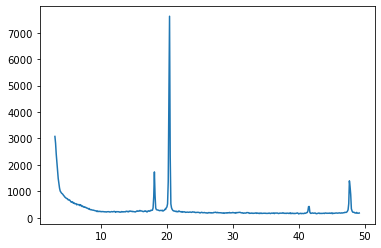

In [242]:
plt.plot(data_spectrum["Angulo(Grados)"],data_spectrum["Imp/s"])

In [243]:
data_spectrum["Angulo(Grados)"]

0       3.0
1       3.1
2       3.2
3       3.3
4       3.4
       ... 
458    48.8
459    48.9
460    49.0
461    49.1
462    49.2
Name: Angulo(Grados), Length: 463, dtype: float64

In [244]:
data_spectrum["Imp/s"]

0      3077
1      2818
2      2408
3      2111
4      1783
       ... 
458     204
459     181
460     173
461     179
462     182
Name: Imp/s, Length: 463, dtype: int64

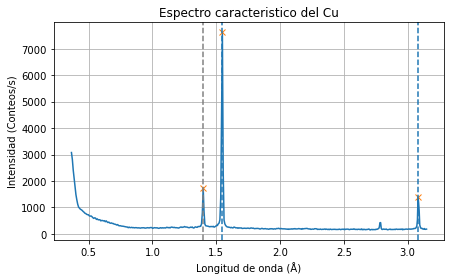

In [245]:
d=2.014*10**(-10)
n=1
Lambda=2*d*np.sin((data_spectrum["Angulo(Grados)"]+2.2)*(np.pi/180))/n  *10**10

fig, ax1 =plt.subplots(1,1,figsize=(7,4))

ax1.plot(Lambda,data_spectrum["Imp/s"])
ax1.grid()
ax1.set_title("Espectro caracteristico del Cu")
ax1.set_xlabel("Longitud de onda (Å)")
ax1.set_ylabel("Intensidad (Conteos/s)")
peaks, _ = find_peaks(data_spectrum["Imp/s"], threshold=100)
results_half = peak_widths(data_spectrum["Imp/s"], peaks, rel_height=0.5)

ax1.plot(Lambda[peaks], data_spectrum["Imp/s"][peaks], "x")
ax1.axvline(Lambda[peaks].to_numpy()[0],ls="--",c="gray")
ax1.axvline(Lambda[peaks].to_numpy()[1],ls="--")
ax1.axvline(Lambda[peaks].to_numpy()[2],ls="--")

plt.savefig("CU_spectrum.pdf",format="pdf")


In [246]:
results_half[0]*[Lambda[11]-Lambda[10]]

array([0.01135485, 0.01324781, 0.02011885])

In [247]:
Lambda[peaks]

151    1.397457
174    1.547942
447    3.081103
Name: Angulo(Grados), dtype: float64

In [248]:
def Lorentzian(x,h,x0,W,D):
    return h*W**2/((x-x0)**2+W**2) + D

#Ajuste Gaussiano
def Gauss(x, y0, a, x0, sigma):
    return y0 + a * np.exp(-(x - x0)**2 / (2 * sigma**2))

#Ajuste de Voight: X x-values, sigma Gaussian standard deviation, gamma Lorentzian full-width at half-maximum
def Voigt(x, amplitude, center, sigma, gamma,D):
    z = ((x - center) + 1j * gamma) / (sigma * np.sqrt(2))
    v = amplitude * wofz(z).real / (sigma * np.sqrt(2 * np.pi))
    return v + D

In [249]:
#Ajuste Lorentziano, como los datos no son del todo continuos, el ancho de la curva a la mitad de la altura se realizó estimando.

x = Lambda.to_numpy()
y = data_spectrum["Imp/s"].to_numpy()
xa = []
ya = []
xb = []
yb = []



for i in range(0,len(x)):
    if x[i]>=1.25 and x[i]<1.45: 
            xb.append(x[i])
            yb.append(y[i])
    if x[i]>=1.40 and x[i]<1.60: 
            xa.append(x[i])
            ya.append(y[i])
    
popt1, pcov1 = curve_fit(Lorentzian,xdata=xb, ydata=yb)
popt11, pcov11 = curve_fit(Lorentzian,xdata=xa, ydata=ya)


ha = popt11[0]
x0a = popt11[1]
Wa = popt11[2]
offseta=popt11[3]
errora = np.sqrt(np.diag(pcov11)) #Desviación estándar dada por el ajuste

hb = popt1[0]
x0b = popt1[1]
Wb = popt1[2]
offsetb=popt1[3]
errorb = np.sqrt(np.diag(pcov1)) #Desviación estándar dada por el ajuste



x1_ = np.linspace(min(x),max(x),500)

#Perfil de Voight
poptgb, pcovgb = curve_fit(Gauss,xdata=xb,ydata=yb)
sigmab = poptgb[3]
poptb, pcovb = curve_fit(Voigt,xdata=xb, ydata=yb,p0=(4500, x0b, sigmab, Wb,200) )
amplitude_fitb, center_fitb, sigma_fitb, gamma_fitb,offsetvb = poptb
errorvb = np.sqrt(np.diag(pcovb))

poptga, pcovga = curve_fit(Gauss,xdata=xa,ydata=ya)
sigmaa = poptga[3]
popta, pcova = curve_fit(Voigt,xdata=xa, ydata=ya,p0=(4500, x0a, sigmaa, Wa,200) )
amplitude_fita, center_fita, sigma_fita, gamma_fita ,offsetva= popta
errorva = np.sqrt(np.diag(pcova))

FWHM_bL=2*popt1[2]

FWHM_aL=2*popt11[2]

FWHM_bg=2*sigmab*np.sqrt(2*np.log(2))##Whiting, E. E. (June 1968). "An empirical approximation to the Voigt profile". Journal of Quantitative Spectroscopy and Radiative Transfer. 8 (6): 1379–1384. Bibcode:1968JQSRT...8.1379W. doi:10.1016/0022-4073(68)90081-2. ISSN 0022-4073.
FWHM_ag=2*sigmaa*np.sqrt(2*np.log(2))##


FWHM_bv=FWHM_bL/2 +np.sqrt(FWHM_bL**2/4 + FWHM_bg**2)
FWHM_av=FWHM_aL/2 +np.sqrt(FWHM_aL**2/4 + FWHM_ag**2)


#Cálculo de energías y longitudes de onda.
print('Ajuste Lorentziano')
print('La longitud de onda de K alfa es {} y de K beta es {} Armstrong; sus incertidumbres son {} y {} respectivamente'.format(round(x0a,3),round(x0b,3),round(FWHM_aL/2,4),round(FWHM_bL/2,3)))
print('Perfil de Voigt')
print('La longitud de onda de K alfa es {} y de K beta es {} Armstrong; sus incertidumbres son {} y {} respectivamente'.format(round(center_fita,3),round(center_fitb,3),round(FWHM_av/2,4),round(FWHM_bv/2,3)))
Ea = 1240 / (x0a/10) #Esto para que quede nm KV/nm
Eb = 1240 / (x0b/10) #Esto para que quede nm KV/nm
print('Las energías para alfa y beta serán {} y {} Kv'.format(round(Ea,3),round(Eb,3)))

#Cálculo de residuales para primer orden


Ajuste Lorentziano
La longitud de onda de K alfa es 1.546 y de K beta es 1.398 Armstrong; sus incertidumbres son 0.0042 y -0.005 respectivamente
Perfil de Voigt
La longitud de onda de K alfa es 1.546 y de K beta es 1.398 Armstrong; sus incertidumbres son 0.0083 y 0.004 respectivamente
Las energías para alfa y beta serán 8020.975 y 8871.623 Kv


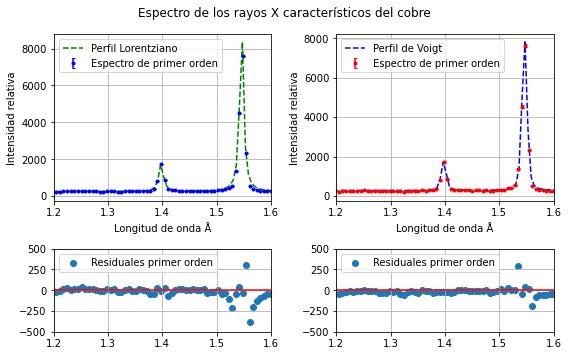

In [250]:
fig, axis = plt.subplots(2,2, figsize = (8, 5), gridspec_kw = {"height_ratios":[2, 1]})
ax1 = axis[0, 0]
ax2 = axis[0, 1]
ax3 = axis[1, 0]
ax4 = axis[1, 1]

fig.suptitle('Espectro de los rayos X característicos del cobre')


ax1.errorbar(x,y,color='b',label=r'Espectro de primer orden',fmt='.',capsize=1.5,yerr=np.sqrt(y) /np.max(y))
ax1.plot(x1_,Lorentzian(x1_,hb,x0b,Wb,offsetb/2)+Lorentzian(x1_,ha,x0a,Wa,offseta/2),'--',color='g',label="Perfil Lorentziano")
ax1.set_xlim(1.2,1.6)
ax1.set_xlabel(r"Longitud de onda Å")
ax1.set_ylabel('Intensidad relativa')
ax1.grid()
ax1.legend()


ax2.errorbar(x,y,color='r',label=r'Espectro de primer orden',fmt='.',capsize=1.5,yerr=np.sqrt(y))
ax2.plot(x1_,Voigt(x1_,amplitude_fitb, center_fitb, sigma_fitb, gamma_fitb,offsetvb/2)+Voigt(x1_,amplitude_fita, center_fita, sigma_fita, gamma_fita,offsetva/2),'--',color='b', label=r'Perfil de Voigt')

ax2.set_xlim(1.2,1.6)

ax2.set_xlabel(r"Longitud de onda Å")
ax2.set_ylabel('Intensidad relativa')
ax2.grid()
ax2.legend()


rL= y -(Lorentzian(x,hb,x0b,Wb,offsetb/2)+Lorentzian(x,ha,x0a,Wa,offseta/2))
ax3.set_xlim(1.2,1.6)
ax3.set_ylim(-500,500)
ax3.plot(x,np.zeros_like(x),color='r')
ax3.scatter(x,rL,label = 'Residuales primer orden')
ax3.grid()
ax3.legend()

rV=y-Voigt(x,amplitude_fitb, center_fitb, sigma_fitb, gamma_fitb,offsetvb/2)-Voigt(x,amplitude_fita, center_fita, sigma_fita, gamma_fita,offsetva/2)
ax4.set_xlim(1.2,1.6)
ax4.set_ylim(-500,500)
ax4.scatter(x,rV,label = 'Residuales primer orden')
ax4.plot(x,np.zeros_like(y),color='r')
ax4.grid()
ax4.legend()

fig.tight_layout()
plt.savefig("Fit_perfiles.pdf",format="pdf")

In [251]:
data2= "datos_sesion2.xlsx"
data_int_v = pd.read_excel(data2,sheet_name=0)

data_int_I = pd.read_excel(data2,sheet_name=1)
data_int_I


,Ángulo del crista,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1
0,17.0,31,51,86,120,131,149,182,239,240,296
1,17.1,24,55,79,105,137,156,194,203,255,283
2,17.2,32,49,91,117,149,166,201,230,253,262
3,17.3,21,64,87,117,145,169,196,204,248,281
4,17.4,23,53,91,130,153,176,202,258,270,285
5,17.5,26,59,88,122,162,195,218,249,277,313
6,17.6,30,69,110,137,172,181,248,266,317,349
7,17.7,52,100,138,186,259,314,353,393,451,458
8,17.8,89,238,363,490,609,710,789,864,943,1057
9,17.9,207,473,669,897,1099,1289,1459,1662,1863,2022


In [252]:
data_int_v

,Ángulo del crista,Tasa con 11kV,Tasa con 13kV,Tasa con 15kV,Tasa con 17kV,Tasa con 19kV,Tasa con 21kV,Tasa con 23kV,Tasa con 25kV,Tasa con 27kV,Tasa con 29kV,Tasa con 31kV,Tasa con 33kV,Tasa con 35kV
0,17.0,13,18,35,45,60,88,121,108,126,165,203,223,265
1,17.1,11,25,33,52,57,87,102,119,146,157,228,240,310
2,17.2,10,22,33,46,60,77,105,131,158,169,201,244,254
3,17.3,9,21,33,50,73,86,114,125,164,171,230,241,280
4,17.4,13,15,38,50,71,79,109,131,152,189,227,253,310
5,17.5,10,27,26,53,68,97,107,129,163,206,224,257,285
6,17.6,9,26,42,52,74,98,131,152,176,237,249,293,348
7,17.7,10,27,58,81,120,145,177,234,270,330,365,399,462
8,17.8,0,67,113,173,231,299,377,445,543,642,669,746,869
9,17.9,38,144,254,385,525,695,899,1054,1231,1443,1618,1802,2003


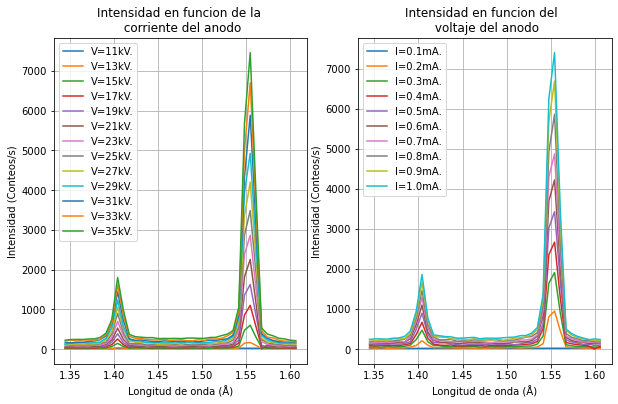

In [253]:
fig2, (ax5,ax6) =plt.subplots(1,2,figsize=(10,6))
Lambda_=2*d*np.sin((data_int_v["Ángulo del crista"]+2.5)*(np.pi/180))/n  *10**10
for i in range(0,13):
    ax5.plot(Lambda_,data_int_v.iloc[:, i],label="V={}kV.".format(11+2*i))
    
for i in range(0,10):
    ax6.plot(Lambda_,data_int_I.iloc[:, i],label="I={}mA.".format(round(0.1+0.1*i,1)))
    
ax5.grid()
ax5.legend()
ax5.set_title("Intensidad en funcion de la \n corriente del anodo")
ax5.set_xlabel("Longitud de onda (Å)")
ax5.set_ylabel("Intensidad (Conteos/s)")

    
ax6.grid()
ax6.legend()
ax6.set_title("Intensidad en funcion del  \n voltaje del anodo")
ax6.set_xlabel("Longitud de onda (Å)")
ax6.set_ylabel("Intensidad (Conteos/s)")


plt.savefig("Intensidad.pdf",format="pdf")

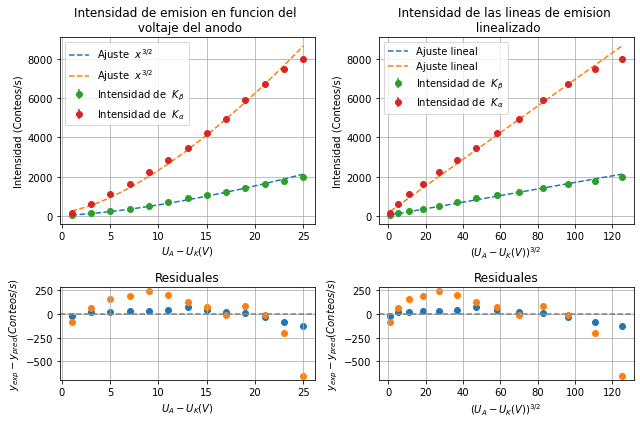

In [254]:

fig3, [(ax7,ax8) ,(res7,res8)] =plt.subplots(2,2,figsize=(9,6),gridspec_kw={'height_ratios': [2, 1]})

peaksV=[]



for  i in range (0,13):
    
    peaksVi, _ = find_peaks(data_int_v.iloc[:,i], threshold=1,distance=20)
    peaksV.append(peaksVi)
    
peaksV[0]=np.array([9,32])
peaksV

Intensity_V=np.zeros([2,13])
Intensity_V[0]=data_int_v.iloc[9,1:]
Intensity_V[1]=data_int_v.iloc[32,1:]

Voltages=np.arange(11,37,2)
U_k=9.979

def linear_function(X, a, b):
    return a * X + b

# Perform the curve fitting


def Poly_function(X, a, b):
    return a * (X)**1.5 + b

# Perform the curve fitting
poptlb, pcovlb = curve_fit(linear_function, (Voltages-U_k)**1.5,Intensity_V[0],sigma=np.sqrt(Intensity_V[0]))
poptla, pcovla = curve_fit(linear_function,(Voltages-U_k)**1.5,Intensity_V[1],sigma=np.sqrt(Intensity_V[1]))

poptpb, pcovpb = curve_fit(Poly_function,(Voltages-U_k),Intensity_V[0],sigma=np.sqrt(Intensity_V[0]))
poptpa, pcovpa = curve_fit(Poly_function,(Voltages-U_k),Intensity_V[1],sigma=np.sqrt(Intensity_V[1]))



ax7.plot(Voltages-U_k ,Poly_function(Voltages-U_k, *poptpb) ,label=r"Ajuste $~ x^{3/2}$",ls="--")
ax7.plot(Voltages-U_k ,Poly_function(Voltages-U_k, *poptpa),label=r"Ajuste $~ x^{3/2}$",ls="--" )
ax7.errorbar(Voltages-U_k,Intensity_V[0],yerr=np.sqrt(Intensity_V[0]),fmt="o",label=r'Intensidad de  $K_{\beta}$ ')
ax7.errorbar(Voltages-U_k,Intensity_V[1],yerr=np.sqrt(Intensity_V[1]),fmt="o",label=r'Intensidad de  $K_{\alpha}$ ')
ax7.set_title("Intensidad de emision en funcion del \n voltaje del anodo")
ax7.set_xlabel(r"$U_A - U_K (V)$")
ax7.set_ylabel("Intensidad (Conteos/s)")
ax7.grid()
ax7.legend()

res7.scatter(Voltages-U_k,Intensity_V[0]-Poly_function(Voltages-U_k, *poptpb),label=r"$K_{\beta}$ ")
res7.scatter(Voltages-U_k,Intensity_V[1]-Poly_function(Voltages-U_k, *poptpa),label=r"$K_{\alpha}$ ")
res7.set_title("Residuales")
res7.set_xlabel(r"$U_A - U_K (V)$")
res7.set_ylabel(r"$y_{exp}-y_{pred} (Conteos/s)$")
res7.axhline(y=0,ls="--",c="gray")
res7.grid()


ax8.plot((Voltages-U_k)**1.5 ,linear_function((Voltages-U_k)**1.5, *poptlb),label="Ajuste lineal",ls="--" )
ax8.plot((Voltages-U_k)**1.5,linear_function((Voltages-U_k)**1.5, *poptla) ,label="Ajuste lineal",ls="--")
ax8.errorbar((Voltages-U_k)**1.5,Intensity_V[0],yerr=np.sqrt(Intensity_V[0]),fmt="o",label=r'Intensidad de  $K_{\beta}$ ')
ax8.errorbar((Voltages-U_k)**1.5,Intensity_V[1],yerr=np.sqrt(Intensity_V[1]),fmt="o",label=r'Intensidad de  $K_{\alpha}$ ')
ax8.set_title("Intensidad de las lineas de emision \n linealizado")
ax8.set_xlabel(r"$(U_A - U_K (V))^{3/2}$")
ax8.set_ylabel("Intensidad (Conteos/s)")
ax8.grid()
ax8.legend()



res8.scatter((Voltages-U_k)**1.5,Intensity_V[0]-linear_function((Voltages-U_k)**1.5, *poptlb),label=r"$K_{\beta}$ ")
res8.scatter((Voltages-U_k)**1.5,Intensity_V[1]-linear_function((Voltages-U_k)**1.5, *poptla),label=r"$K_{\alpha}$ ")
res8.set_title("Residuales")
res8.set_xlabel(r"$(U_A - U_K (V))^{3/2}$")
res8.set_ylabel(r"$y_{exp}-y_{pred} (Conteos/s)$")
res8.axhline(y=0,ls="--",c="gray")
res8.grid()

plt.tight_layout()

plt.savefig("Intenisity_V_fit.pdf",format="pdf")


In [289]:
b_lb=ufloat(poptlb[0],np.sqrt(pcovlb[0,0])) 
b_pb=ufloat(poptpb[0],np.sqrt(pcovpb[0,0])) 

b_la=ufloat(poptla[0],np.sqrt(pcovla[0,0])) 
b_pa=ufloat(poptpa[0],np.sqrt(pcovpa[0,0])) 


print(b_lb,b_pb,b_la,b_pa)

16.7+/-0.4 16.7+/-0.4 67.7+/-1.6 67.7+/-1.6


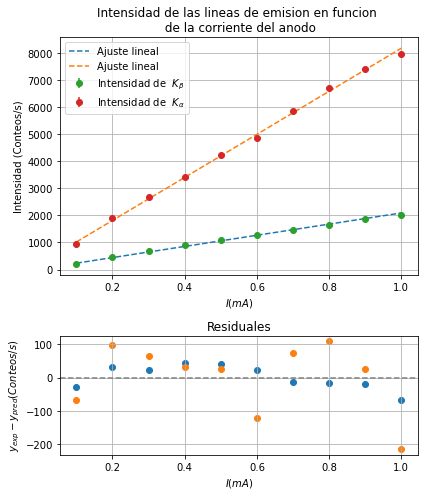

In [256]:


fig4, (ax9 ,res9) =plt.subplots(2,1,figsize=(6,7), gridspec_kw={'height_ratios': [2, 1]})

peaksI=[]

for  i in range (0,10):
    
    peaksIi, _ = find_peaks(data_int_I.iloc[:,i], threshold=1,distance=20)
    peaksI.append(peaksIi)
    
peaksI[0]=np.array([9,32])
peaksI

Intensity_I=np.zeros([2,10])
Intensity_I[0]=data_int_I.iloc[9,1:]
Intensity_I[1]=data_int_I.iloc[32,1:]

Currents=np.arange(0.1,1.1,0.1)

poptlbI, pcovlbI = curve_fit(linear_function, Currents,Intensity_I[0],sigma=np.sqrt(Intensity_I[0]))
poptlaI, pcovlaI = curve_fit(linear_function,Currents,Intensity_I[1],sigma=np.sqrt(Intensity_I[1]))




ax9.plot(Currents ,linear_function(Currents, *poptlbI) ,label="Ajuste lineal",ls="--")
ax9.plot(Currents ,linear_function(Currents, *poptlaI),label="Ajuste lineal",ls="--" )
ax9.errorbar(Currents,Intensity_I[0],yerr=np.sqrt(Intensity_I[0]),fmt="o",label=r'Intensidad de  $K_{\beta}$ ')
ax9.errorbar(Currents,Intensity_I[1],yerr=np.sqrt(Intensity_I[1]),fmt="o",label=r'Intensidad de  $K_{\alpha}$ ')
ax9.set_title("Intensidad de las lineas de emision en funcion \n de la corriente del anodo")
ax9.set_xlabel(r"$I(mA)$")
ax9.set_ylabel("Intensidad (Conteos/s)")
ax9.grid()
ax9.legend()

res9.scatter(Currents ,Intensity_I[0]-linear_function(Currents, *poptlbI),label=r"$K_{\beta}$ ")
res9.scatter(Currents ,Intensity_I[1]-linear_function(Currents, *poptlaI),label=r"$K_{\alpha}$ ")
res9.set_title("Residuales")
res9.set_xlabel(r"$I(mA)$")
res9.set_ylabel(r"$y_{exp}-y_{pred} (Conteos/s)$")
res9.axhline(y=0,ls="--",c="gray")
res9.grid()

plt.tight_layout()
plt.savefig("Intenisity_I_fit.pdf",format="pdf")

In [295]:
b_lbI=ufloat(poptlbI[0],np.sqrt(pcovlbI[0,0]))/(35-U_k)**1.5

b_laI=ufloat(poptlaI[0],np.sqrt(pcovlaI[0,0])) /(35-U_k)**1.5



print(b_lbI,b_laI)

16.46+/-0.33 63.5+/-0.9


In [257]:
data2= "datos_sesion2.xlsx"
data_Al = pd.read_excel(data2,sheet_name=2)
d_Al=[0.2,0.4,0.6,0.8,1]

data_Zn = pd.read_excel(data2,sheet_name=3)
data_Zn


data_0 = pd.read_excel(data,sheet_name=1)


In [258]:

data_0

,Ángulo del crista,Tasa con 30kV
0,6,365
1,7,295
2,8,225
3,9,169
4,10,136
5,11,135
6,12,137
7,13,137
8,14,145
9,15,149


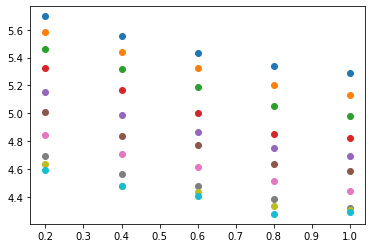

In [259]:
for i in range(0,10):
    plt.scatter(d_Al,np.log(data_Al.iloc[i,1:]))

In [277]:

Data_4=pd.read_csv("Data_4.txt",sep=",")
Data_4

,angulo,23,25,27,29,31,33,35
0,14.0,1.0,2.0,4.0,11.0,4.0,5.0,12.0
1,14.1,3.0,5.0,5.0,4.0,7.0,9.0,10.0
2,14.2,5.0,3.0,5.0,5.0,6.0,5.0,11.0
3,14.3,3.0,5.0,6.0,6.0,7.0,8.0,6.0
4,14.4,5.0,4.0,6.0,4.0,10.0,6.0,15.0
...,...,...,...,...,...,...,...,...
106,24.6,3.0,3.0,6.0,6.0,9.0,11.0,7.0
107,24.7,3.0,5.0,4.0,4.0,7.0,9.0,11.0
108,24.8,3.0,3.0,2.0,8.0,7.0,7.0,7.0
109,24.9,2.0,3.0,3.0,8.0,3.0,6.0,11.0


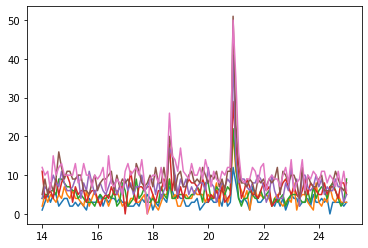

In [280]:
for i in range(1,8):
    plt.plot(Data_4.iloc[:, 0],Data_4.iloc[:, i])